# Run Backtest - Crypto Spread Arbitrage

## Global Imports

In [1]:
import itertools
import logging
import os
import pickle
from datetime import date, datetime, timedelta

import cryptomart as cm
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyutil
import requests
import vectorbt as vbt

import app
from app import bq_util
from app.enums import Exchange, InstrumentType, Interval, OHLCVColumn, SpreadColumn
from app.errors import BigQueryError, ExchangeAPIError, MissingDataError, NotSupportedError
from app.feeds import Spread
from app.globals import STUDY_END_DATE, STUDY_INST_TYPES, STUDY_START_DATE, STUDY_TIME_RANGE
from app.vbt_backtest_chained import from_order_func_wrapper_chained

# Global APIs / Constants
cm_client = cm.Client(quiet=True)

# We may have different identifiers for different strategies / different datasets used
backtest_identifier = "spread_arb_v1"
z_score_period = 30
data_start_filter = pd.to_datetime(datetime(2022, 4, 9))


## Prepare Data

### Instrument Level Data

In [2]:
@pyutil.cache.cached("/tmp/cache/all_order_book_stats", refresh=False, identifiers=[backtest_identifier])
def all_order_book_stats() -> pd.DataFrame:
    """Get gaps and first_date for all instruments in Order Book data mart"""
    all_stats = pd.DataFrame(index=pd.MultiIndex.from_arrays([[], [], []], names=["exchange", "inst_type", "symbol"]))

    for exchange in Exchange:
        for inst_type in STUDY_INST_TYPES:
            instruments = cm_client.instrument_info(exchange, inst_type)
            for symbol in Symbol:
                if symbol not in instruments["cryptomart_symbol"].to_list():
                    continue
                try:
                    instrument_stats = bq_util.get_order_book_stats(
                        exchange, symbol, app.enums.InstrumentType.PERP, cache_kwargs={"disabled": False}
                    )
                    instrument_stats.rename(columns=lambda c: f"order_book_{c}", inplace=True)
                except BigQueryError:
                    # Instrument does not exist in BigQuery database
                    continue
                all_stats.at[(exchange, inst_type, symbol), instrument_stats.columns] = instrument_stats.iloc[0].values

    return all_stats


@pyutil.cache.cached("/tmp/cache/all_bid_ask_spreads", refresh=False, identifiers=[backtest_identifier])
def all_bid_ask_spreads() -> pd.DataFrame:
    """Get the bid ask spread timeseries for all instruments in the Order Book data mart"""
    ba_spreads = pd.DataFrame(index=pd.MultiIndex.from_arrays([[], [], []], names=["exchange", "inst_type", "symbol"]))

    for exchange in Exchange:
        for inst_type in STUDY_INST_TYPES:
            instruments = cm_client.instrument_info(exchange, inst_type)
            for symbol in Symbol:
                if symbol not in instruments["cryptomart_symbol"].to_list():
                    continue
                try:
                    ba_spread = bq_util.get_bid_ask_spread(
                        exchange,
                        symbol,
                        app.enums.InstrumentType.PERP,
                        cache_kwargs={"disabled": False, "refresh": True},
                    )
                except BigQueryError:
                    # Instrument does not exist in BigQuery database
                    continue
                ba_spreads.at[(exchange, inst_type, symbol), "bid_ask_spread"] = pickle.dumps(ba_spread)

    return ba_spreads


@pyutil.cache.cached("/tmp/cache/all_funding_rates", refresh=False, identifiers=[backtest_identifier])
def all_funding_rates() -> pd.DataFrame:
    """Get the funding rate timeseries for all instruments"""
    funding_rates = pd.DataFrame(
        index=pd.MultiIndex.from_arrays([[], [], []], names=["exchange", "inst_type", "symbol"])
    )

    for exchange in Exchange:
        for inst_type in STUDY_INST_TYPES:
            instruments = cm_client.instrument_info(exchange, inst_type)
            for symbol in Symbol:
                if symbol not in instruments["cryptomart_symbol"].to_list():
                    continue
                try:
                    fr = cm_client.funding_rate(exchange, symbol, *STUDY_TIME_RANGE, cache_kwargs={"disabled": False})
                except NotSupportedError:
                    # Instrument not supported by exchange
                    continue
                funding_rates.at[(exchange, inst_type, symbol), "funding_rate"] = pickle.dumps(fr)

    return funding_rates


@pyutil.cache.cached("/tmp/cache/all_ohlcv", refresh=False, identifiers=[backtest_identifier])
def all_ohlcv() -> pd.DataFrame:
    """Get OHLCV for all instruments"""
    ohlcvs = pd.DataFrame(index=pd.MultiIndex.from_arrays([[], [], []], names=["exchange", "inst_type", "symbol"]))

    for exchange in Exchange:
        for inst_type in STUDY_INST_TYPES:
            instruments = cm_client.instrument_info(exchange, inst_type)
            for symbol in Symbol:
                if symbol not in instruments["cryptomart_symbol"].to_list():
                    continue
                try:
                    fr = cm_client.ohlcv(
                        exchange,
                        symbol,
                        inst_type,
                        list(map(lambda d: (d.year, d.month, d.day), [date(2022, 6, 19) - timedelta(days=z_score_period)]))[0],
                        STUDY_END_DATE,
                        cache_kwargs={"disabled": False},
                    )
                except NotSupportedError:
                    # Instrument not supported by exchange
                    continue
                ohlcvs.at[(exchange, inst_type, symbol), "ohlcv"] = pickle.dumps(fr)

    return ohlcvs


order_book_stats = all_order_book_stats()
funding_rates = all_funding_rates()
ohlcvs = all_ohlcv()
bid_ask_spreads = all_bid_ask_spreads()

instrument_data = (
    funding_rates.merge(bid_ask_spreads, left_index=True, right_index=True)
    .merge(ohlcvs, left_index=True, right_index=True)
    .merge(order_book_stats, left_index=True, right_index=True)
)


2022-09-09 20:29:35.783 INFO     pyutil.cache                                                                      log:87   Saving cached value in call to instrument_info((id:bitmex_instrument_info_perpetual), map_column=None) | key=102db0d884c9f83467f25d33441fc98a (/tmp/cache/instrument_info/bitmex/perpetual)


NameError: name 'Symbol' is not defined

### Filter instruments by date and number of gaps

In [2]:
# TODO: parallelize me
for idx, row in instrument_data.iterrows():
    bid_ask_spread = pickle.loads(row.bid_ask_spread)
    funding_rate = pickle.loads(row.funding_rate)
    ohlcv = pickle.loads(row.ohlcv)

    # Filter start times using global data_start_filter
    bid_ask_spread = bid_ask_spread[bid_ask_spread.date >= data_start_filter]
    funding_rate = funding_rate[funding_rate.timestamp >= data_start_filter]
    ohlcv = ohlcv[ohlcv.open_time >= data_start_filter - pd.Timedelta(z_score_period, "days")]

    instrument_data.at[idx, "bid_ask_spread"] = pickle.dumps(bid_ask_spread)

    instrument_data.at[idx, "funding_rate"] = pickle.dumps(funding_rate)
    instrument_data.at[idx, "funding_rate_gaps"] = funding_rate.gaps
    instrument_data.at[idx, "funding_rate_first_date"] = funding_rate.earliest_time

    instrument_data.at[idx, "ohlcv"] = pickle.dumps(ohlcv)
    instrument_data.at[idx, "ohlcv_gaps"] = ohlcv.gaps
    instrument_data.at[idx, "ohlcv_first_date"] = ohlcv.earliest_time


# Drop rows with too many funding rate gaps / ohlcv gaps
fr_gap_thres = 3
ohlcv_gap_thres = 3
mask = (instrument_data.funding_rate_gaps <= instrument_data.funding_rate_gaps.std() * fr_gap_thres) & (
    instrument_data.ohlcv_gaps <= instrument_data.ohlcv_gaps.std() * ohlcv_gap_thres
)

instrument_data_dropped_rows = instrument_data[~mask]
instrument_data = instrument_data[mask]


NameError: name 'instrument_data' is not defined

### Fee and Margin Data

In [ ]:
# Exchange-wide taker fee: https://www.binance.com/en/fee/futureFee
logging.getLogger("pyutil.cache").setLevel("WARNING")

# BINANCE
fee_info_binance = cm_client.binance.instrument_info("perpetual")
fee_info_binance = fee_info_binance.set_index("cryptomart_symbol").rename_axis(index="symbol")
fee_info_binance = (
    fee_info_binance[["maintMarginPercent", "requiredMarginPercent"]]
    .rename(columns={"maintMarginPercent": "maint_margin", "requiredMarginPercent": "init_margin"})
    .astype(float)
    .apply(lambda x: x / 100)
)
fee_info_binance = fee_info_binance.assign(fee_pct=0.0004, fee_fixed=0)


# BITMEX
fee_info_bitmex = cm_client.bitmex.instrument_info("perpetual")
fee_info_bitmex = fee_info_bitmex.set_index("cryptomart_symbol").rename_axis(index="symbol")
fee_info_bitmex = fee_info_bitmex[["maintMargin", "initMargin", "takerFee"]].rename(
    columns={"maintMargin": "maint_margin", "initMargin": "init_margin", "takerFee": "fee_pct"}
)
fee_info_bitmex = fee_info_bitmex.assign(fee_fixed=0)


# BYBIT
@pyutil.cache.cached("/tmp/cache/fee_margin_data", refresh=False, path_seperators=["exchange"])
def bybit_get_single_margin(exchange_symbol, exchange="bybit"):
    url = os.path.join(cm_client.bybit.base_url, "public", "linear", "risk-limit")
    params = {"symbol": exchange_symbol}
    request = requests.Request("GET", url=url, params=params)
    response = cm_client.bybit.dispatcher.send_request(request)
    response = cm.interfaces.api.APIInterface.extract_response_data(
        response, ["result"], ["ret_code"], 0, ["ret_msg"], raw=True
    )
    risk_tiers = pd.DataFrame(response)
    lowest_risk_tier = risk_tiers[risk_tiers.limit == risk_tiers.limit.min()]
    return (
        lowest_risk_tier[["maintain_margin", "starting_margin"]]
        .rename(columns={"maintain_margin": "maint_margin", "starting_margin": "init_margin"})
        .iloc[0]
    )


fee_info_bybit = cm_client.bybit.instrument_info("perpetual")
fee_info_bybit = fee_info_bybit.set_index("cryptomart_symbol").rename_axis(index="symbol")

fee_info_bybit = pd.concat([fee_info_bybit, fee_info_bybit.exchange_symbol.apply(bybit_get_single_margin)], axis=1)
fee_info_bybit = fee_info_bybit[["maint_margin", "init_margin", "taker_fee"]].rename(columns={"taker_fee": "fee_pct"})
fee_info_bybit = fee_info_bybit.assign(fee_fixed=0)


# COINFLEX
# CoinFLEX does not provide information on maint margin / initial margin. Set to NaN and fill with the average of the other exchanges
# Exchange-wide taker fee: https://coinflex.com/fees/
fee_info_coinflex = cm_client.coinflex.instrument_info("perpetual")
fee_info_coinflex = fee_info_coinflex.set_index("cryptomart_symbol").rename_axis(index="symbol")[[]]
fee_info_coinflex = fee_info_coinflex.assign(maint_margin=np.nan, init_margin=np.nan)
fee_info_coinflex = fee_info_coinflex.assign(fee_pct=0.0005, fee_fixed=0)


# FTX
# FTX has a complex margin scheme. Set to NaN and fill with the average of the other exchanges
# Exchange-wide taker fee: https://help.ftx.com/hc/en-us/articles/360024479432-Fees
fee_info_ftx = cm_client.ftx.instrument_info("perpetual")
fee_info_ftx = fee_info_ftx.set_index("cryptomart_symbol").rename_axis(index="symbol")[[]]
fee_info_ftx = fee_info_ftx.assign(maint_margin=np.nan, init_margin=np.nan)
fee_info_ftx = fee_info_ftx.assign(fee_pct=0.0007, fee_fixed=0)


# GATEIO
# gateio does not provide init margin rate. Set to NaN and fill with the average of the other exchanges
fee_info_gateio = cm_client.gateio.instrument_info("perpetual")
fee_info_gateio = fee_info_gateio.set_index("cryptomart_symbol").rename_axis(index="symbol")
fee_info_gateio = fee_info_gateio[["taker_fee_rate", "maintenance_rate"]].rename(
    columns={"taker_fee_rate": "fee_pct", "maintenance_rate": "maint_margin"}
)
fee_info_gateio = fee_info_gateio.assign(init_margin=np.nan)
fee_info_gateio = fee_info_gateio.assign(fee_fixed=0)
fee_info_gateio = fee_info_gateio[["maint_margin", "init_margin", "fee_pct", "fee_fixed"]]


# KUCOIN
fee_info_kucoin = cm_client.kucoin.instrument_info("perpetual")
fee_info_kucoin = fee_info_kucoin.set_index("cryptomart_symbol").rename_axis(index="symbol")
fee_info_kucoin = fee_info_kucoin[["maintainMargin", "initialMargin", "takerFeeRate", "makerFixFee"]].rename(
    columns={
        "maintainMargin": "maint_margin",
        "initialMargin": "init_margin",
        "takerFeeRate": "fee_pct",
        "makerFixFee": "fee_fixed",
    }
)


# OKEX
# Exchange-wide taker fee: https://www.okx.com/fees
@pyutil.cache.cached("/tmp/cache/fee_margin_data", refresh=False, path_seperators=["exchange"])
def okex_get_single_margin(exchange_symbol, exchange="okex"):
    url = os.path.join(cm_client.okex.base_url, "api", "v5", "public", "position-tiers")
    params = {"instType": "SWAP", "tdMode": "isolated", "uly": exchange_symbol}
    request = requests.Request("GET", url=url, params=params)
    response = cm_client.okex.dispatcher.send_request(request)
    response = cm.interfaces.api.APIInterface.extract_response_data(
        response, ["data"], ["code"], "0", ["msg"], raw=True
    )
    risk_tiers = pd.DataFrame(response)
    return (
        risk_tiers.loc[risk_tiers.tier == "2", ["mmr", "imr"]]
        .rename(columns={"mmr": "maint_margin", "imr": "init_margin"})
        .iloc[0]
    )


fee_info_okex = cm_client.okex.instrument_info("perpetual")
fee_info_okex = fee_info_okex.set_index("cryptomart_symbol").rename_axis(index="symbol")
fee_info_okex = pd.concat([fee_info_okex, fee_info_okex.uly.apply(okex_get_single_margin)], axis=1)
fee_info_okex = fee_info_okex[["maint_margin", "init_margin"]]
fee_info_okex = fee_info_okex.assign(fee_pct=0.0005, fee_fixed=0)

logging.getLogger("pyutil.cache").setLevel("INFO")


# Join with instrument_data
DEFAULT_INIT_MARGIN = 0
DEFAULT_MAINT_MARGIN = 0.15
all_fee_info = pd.concat(
    [
        fee_info_binance,
        fee_info_bitmex,
        fee_info_bybit,
        fee_info_coinflex,
        fee_info_ftx,
        fee_info_gateio,
        fee_info_kucoin,
        fee_info_okex,
    ],
    keys=["binance", "bitmex", "bybit", "coinflex", "ftx", "gateio", "kucoin", "okex"],
    names=["exchange"],
)

all_fee_info = (
    all_fee_info.astype(float)
    .groupby("symbol")
    .apply(lambda c: c.fillna(c.mean()))
    .fillna({"init_margin": DEFAULT_INIT_MARGIN, "maint_margin": DEFAULT_MAINT_MARGIN})
)

instrument_data = instrument_data.join(all_fee_info).reorder_levels(instrument_data.index.names)


### Spread Level Data

In [ ]:
instrument_data_crossed = (
    instrument_data.reset_index()
    .merge(instrument_data.reset_index(), how="cross", suffixes=("_a", "_b"))
    .pipe(
        lambda df: df[
            (df.exchange_a < df.exchange_b) & (df.inst_type_a <= df.inst_type_b) & (df.symbol_a == df.symbol_b)
        ]
    )
    .drop(columns="symbol_b")
    .rename(columns={"symbol_a": "symbol"})
    .reset_index(drop=True)
)

# TODO: parallelize me
spreads = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(
        [[], [], [], [], []], names=["exchange_a", "exchange_b", "inst_type_a", "inst_type_b", "symbol"]
    )
)

for idx, row in instrument_data_crossed.iterrows():
    indexer_a = (row.exchange_a, row.inst_type_a, row.symbol)
    indexer_b = (row.exchange_b, row.inst_type_b, row.symbol)
    indexer = (row.exchange_a, row.exchange_b, row.inst_type_a, row.inst_type_b, row.symbol)
    spread = Spread.from_ohlcv(pickle.loads(row.ohlcv_a), pickle.loads(row.ohlcv_b))

    bid_ask_a = pickle.loads(bid_ask_spreads.at[indexer_a, "bid_ask_spread"])
    bid_ask_b = pickle.loads(bid_ask_spreads.at[indexer_b, "bid_ask_spread"])
    fr_a = pickle.loads(funding_rates.at[indexer_a, "funding_rate"])
    fr_b = pickle.loads(funding_rates.at[indexer_b, "funding_rate"])

    spread.add_bid_ask_spread(bid_ask_a, bid_ask_b)
    spread.add_funding_rate(fr_a, fr_b)

    spreads.at[indexer, "spread"] = pickle.dumps(spread)
    spreads.at[
        indexer, "alias"
    ] = f"{row.exchange_a[:4]}_{row.exchange_b[:4]}_{row.inst_type_a[:4]}_{row.inst_type_b[:4]}_{row.symbol}"
    spreads.at[indexer, "volatility"] = spread.volatility()
    spreads.at[indexer, (f"avg_ba_spread_{s}" for s in ("a", "b"))] = set(
        x.bid_ask_spread.mean() for x in (bid_ask_a, bid_ask_b)
    )
    spreads.at[indexer, "earliest_time"] = spread.earliest_time
    spreads.at[indexer, "latest_time"] = spread.latest_time
    spreads.at[indexer, "valid_rows"] = len(spread.valid_rows)
    spreads.at[indexer, "missing_rows"] = len(spread.missing_rows)
    spreads.at[indexer, "gaps"] = spread.gaps

    fee_info_keys = ["init_margin", "maint_margin", "fee_pct", "fee_fixed"]
    for key in ["a", "b"]:
        spreads.at[indexer, f"fee_info_{key}"] = pickle.dumps({k: getattr(row, f"{k}_{key}") for k in fee_info_keys})


# Optional: filter spreads by volatility, valid_rows, gaps, etc...


### Save Data for backtest

In [ ]:
spreads.to_pickle("spreads.pkl")

## Run backtest

### Vbt Interface

In [2]:
class BacktestResult:
    def __init__(self, portfolio: vbt.Portfolio, feed: Spread):
        self.portfolio = portfolio
        self.feed = feed

    def slippage(self) -> pd.DataFrame:
        """Return slippage paid by day.
        
        Returns dataframe with datetime index and columns [exchange_0, exchange_1]
        """
        close_prices = self.feed.underlying_col("close").droplevel(1, axis=1).rename(columns=lambda c: c.split(".")[1])
        filled_prices = (
            self.portfolio.orders.records_readable.groupby(["Timestamp", "Column"])
            .first()
            .Price.unstack()
            .rename(columns=lambda c: c.split(".")[1])
        )
        sizes = (
            self.portfolio.orders.records_readable.groupby(["Timestamp", "Column"])
            .sum()
            .Size.unstack("Column")
            .rename(columns=lambda c: c.split(".")[1])
        )
        return abs(close_prices - filled_prices) * sizes

    def plot(self) -> go.FigureWidget:
        """Return FigureWidget with plots for Spread, Zscore, Price, PnL, Returns, Slippage"""
        portfolio = self.portfolio
        feed = self.feed

        df = portfolio.trades.records.sort_values(["entry_idx", "col"])
        # For column 0, a short means we are long on the spread and vice versa
        df = df[df.col == 0]

        # direction 1 = short
        # direction 0 = long
        long_trades = df[df.direction == 1]
        short_trades = df[df.direction == 0]

        temp_signals = np.zeros(len(feed))
        temp_signals[long_trades.entry_idx] = True
        long_entries = pd.Series(index=feed[feed.time_column], data=temp_signals).astype(bool)

        temp_signals = np.zeros(len(feed))
        temp_signals[long_trades.exit_idx] = True
        long_exits = pd.Series(index=feed[feed.time_column], data=temp_signals).astype(bool)

        temp_signals = np.zeros(len(feed))
        temp_signals[short_trades.entry_idx] = True
        short_entries = pd.Series(index=feed[feed.time_column], data=temp_signals).astype(bool)

        temp_signals = np.zeros(len(feed))
        temp_signals[short_trades.exit_idx] = True
        short_exits = pd.Series(index=feed[feed.time_column], data=temp_signals).astype(bool)

        fig = vbt.make_subplots(rows=8, cols=1, shared_xaxes=True, vertical_spacing=0.05)
        spread = feed.set_index(feed.time_column).close
        zscore = feed.zscore()

        spread.vbt.plot(add_trace_kwargs=dict(row=1, col=1), fig=fig, title=feed._underlying_info)
        zscore.vbt.plot(add_trace_kwargs=dict(row=2, col=1), fig=fig)

        # Plot entry and exit markers on z-score
        short_entries.vbt.signals.plot_as_exit_markers(
            zscore,
            add_trace_kwargs=dict(row=2, col=1),
            trace_kwargs=dict(marker=dict(opacity=0.4, size=12, color="green"), name="short_entry"),
            fig=fig,
        )
        short_exits.vbt.signals.plot_as_entry_markers(
            zscore,
            add_trace_kwargs=dict(row=2, col=1),
            trace_kwargs=dict(marker=dict(opacity=0.4, size=12, color="red"), name="short_exit"),
            fig=fig,
        )
        long_entries.vbt.signals.plot_as_entry_markers(
            zscore,
            add_trace_kwargs=dict(row=2, col=1),
            trace_kwargs=dict(marker=dict(opacity=0.8), name="long_entry"),
            fig=fig,
        )
        long_exits.vbt.signals.plot_as_exit_markers(
            zscore,
            add_trace_kwargs=dict(row=2, col=1),
            trace_kwargs=dict(marker=dict(opacity=0.8), name="long_exit"),
            fig=fig,
        )

        # Plot individual close prices
        feed.underlying_col("close").droplevel(1, axis=1).rename(
            columns=lambda c: c.split(".")[1] + " close price"
        ).vbt.plot(add_trace_kwargs=dict(row=3, col=1), fig=fig)

        # Plot daily returns
        (portfolio.returns() * 100).rename("% returns").vbt.scatterplot(add_trace_kwargs=dict(row=4, col=1), fig=fig)

        # Plot order entry and exit prices
        orders = portfolio.orders.records_readable
        if len(orders) > 0:
            orders["Side"] = orders["Side"].replace({"Sell": -1, "Buy": 1})
            orders["Price"] = orders["Price"] * orders["Side"]
            orders["When"] = pd.concat(
                [pd.Series(["entry", "exit"]).repeat(2)] * int(np.ceil(len(orders) / 4)), ignore_index=True
            ).values[: len(orders)]
            orders = orders.set_index(["Timestamp", "Column", "When"])
            orders = orders.unstack(["Column", "When"]).Price.rename(
                columns=lambda c: c.split(".")[1] + " fill price", level=0
            )
            orders.vbt.scatterplot(add_trace_kwargs=dict(row=5, col=1), fig=fig)

        # Plot daily PnL
        self.portfolio.trades.records_readable.sort_values("Entry Timestamp").groupby(
            "Entry Timestamp"
        ).PnL.sum().reindex(self.feed.open_time).fillna(0).rename("PnL").vbt.scatterplot(
            add_trace_kwargs=dict(row=6, col=1), fig=fig
        )

        # Plot cumulative returns
        (portfolio.cumulative_returns() * 100).rename("cumulative returns").vbt.plot(
            add_trace_kwargs=dict(row=7, col=1), fig=fig
        )

        # Plot slippage
        self.slippage().vbt.scatterplot(add_trace_kwargs=dict(row=8, col=1), fig=fig)

        fig.update_layout(height=1200, width=1800, hovermode="x unified", hoverlabel={"namelength": -1}, legend=None)
        fig.add_shape(
            type="rect",
            xref="paper",
            yref="y2",
            x0=0,
            y0=1,
            x1=1,
            y1=-1,
            fillcolor="gray",
            opacity=0.2,
            layer="below",
            line_width=0,
        )

        return fig

    def analyze(self):
        """Display plots, session stats, trades, orders, underlying prices"""
        display(self.plot())
        display(f"slippage: {self.slippage().sum().sum()}")
        display(self.aggregate_stats())
        display(self.portfolio.stats())
        display(self.portfolio.trades.records_readable.sort_values("Entry Timestamp").head(10))
        display(self.portfolio.orders.records_readable.sort_values("Timestamp").head(20))
        display(self.feed.underlyings)

    def get_leg_trades(self) -> pd.DataFrame:
        """Return DataFrame with additional stats per leg for each trade"""
        portfolio = self.portfolio
        orders = portfolio.orders.records_readable.sort_values("Timestamp")
        orders["col"] = portfolio.orders.records.sort_values("idx").col
        try:
            orders["When"] = pd.concat([pd.Series(["entry", "exit"]).repeat(2)] * int(np.ceil(len(orders) / 4)), ignore_index=True).values[: len(orders)]
        except ValueError:
            orders["When"] = pd.Series()
        orders = orders.rename(columns={"Price": "filled_price", "Size": "size"})

        close_prices = self.feed.underlying_col("close").droplevel(1, axis=1).set_axis([0, 1], axis=1).melt(var_name="col", value_name="close", ignore_index=False).reset_index().rename(columns={"open_time": "Timestamp"})
        slippage = orders.merge(close_prices)

        slippage["slippage"] = abs(slippage["close"] - slippage["filled_price"]) * slippage["size"]
        slippage = slippage[["Timestamp", "col", "slippage", "When"]]
        entry_slippage = slippage[slippage.When == "entry"].rename(columns={"slippage": "entry_slippage", "Timestamp": "Entry Timestamp"}).drop(columns="When")
        exit_slippage = slippage[slippage.When == "exit"].rename(columns={"slippage": "exit_slippage", "Timestamp": "Exit Timestamp"}).drop(columns="When")

        leg_trades = portfolio.trades.records_readable.sort_values("Entry Timestamp")
        leg_trades["col"] = portfolio.trades.records.sort_values("entry_idx").col
        leg_trades = leg_trades.merge(self.feed.zscore(period=self.feed.zscore_period).rename("entry_zscore"), left_on="Entry Timestamp", right_index=True)
        leg_trades = leg_trades.merge(self.feed.zscore(period=self.feed.zscore_period).rename("exit_zscore"), left_on="Exit Timestamp", right_index=True)
        leg_trades = leg_trades.merge(portfolio.cash().rename("entry_cash"), left_on="Entry Timestamp", right_index=True)
        leg_trades = leg_trades.merge(portfolio.cash().rename("exit_cash"), left_on="Exit Timestamp", right_index=True)
        leg_trades = leg_trades.merge(entry_slippage)
        leg_trades = leg_trades.merge(exit_slippage, how="left") # Left merge because last trade may not be closed
        leg_trades = leg_trades.merge(close_prices.rename(columns={"Timestamp": "Entry Timestamp"})).rename(columns={"close": "entry_price"})
        leg_trades = leg_trades.merge(close_prices.rename(columns={"Timestamp": "Exit Timestamp"})).rename(columns={"close": "exit_price"})

        leg_trades["slippage"] = leg_trades["entry_slippage"] + leg_trades["exit_slippage"]
        leg_trades["fees"] = leg_trades["Entry Fees"] + leg_trades["Exit Fees"]
        leg_trades.rename(columns={"PnL": "PnL w fees"}, inplace=True)
        leg_trades["raw PnL"] = leg_trades["PnL w fees"] + leg_trades["fees"]
        leg_trades["PnL w slip"] = leg_trades["raw PnL"] - leg_trades["slippage"]
        leg_trades["PnL w slip + fees"] = leg_trades["PnL w fees"] - leg_trades["slippage"]
        
        return leg_trades


    @staticmethod
    def group_trades(g: pd.DataFrame, sum_legs=False) -> pd.DataFrame:
        """Apply method for aggregating leg trades grouped by Entry Timestamp"""
        out = pd.DataFrame()
        entry_time = g["Entry Timestamp"].iloc[0]
        exit_time = g["Exit Timestamp"].iloc[0]
        names = g.Column.to_list()
        status = g.Status.to_list()
        directions = g.Direction.replace("Short", -1).replace("Long", 1).to_list()
        spread_dir = 1 if directions[0] == -1 else -1
        
        if (g.Status == "Closed").all():
            overall_status = "Closed"
        elif (g.Status == "Open").any():
            overall_status = "Open"
        elif (g.status == "Rejected").any():
            overall_status = "Rejected"
        else:
            overall_status = f"{g.Status.iloc[0]} / {g.Status.iloc[1]}"

        entry_fees = g["Entry Fees"].to_list()
        exit_fees = g["Exit Fees"].to_list()
        total_fees = (g["Entry Fees"] + g["Exit Fees"]).to_list()

        entry_slippage = g["entry_slippage"].to_list()
        exit_slippage = g["exit_slippage"].to_list()
        total_slippage = (g["entry_slippage"] + g["exit_slippage"]).to_list()

        raw_pnl = g["raw PnL"].to_list()
        pnl_w_fees = g["PnL w fees"].to_list()
        pnl_w_slip = g["PnL w slip"].to_list()
        pnl_w_slip_fees = g["PnL w slip + fees"].to_list()

        entry_prices = g["entry_price"].to_list()
        exit_prices = g["exit_price"].to_list()
        entry_zscore = g["entry_zscore"].iloc[0]
        exit_zscore = g["exit_zscore"].iloc[0]
        filled_entry_prices = g["Avg Entry Price"].to_list()
        filled_exit_prices = g["Avg Exit Price"].to_list()
        sizes = g["Size"].to_list()
        entry_spread = entry_prices[1] - entry_prices[0]
        exit_spread = exit_prices[1] - exit_prices[0]
        filled_entry_spread = filled_entry_prices[1] - filled_entry_prices[0]
        filled_exit_spread = filled_exit_prices[1] - filled_exit_prices[0]
        
        spread_change = (exit_spread - entry_spread) * spread_dir
        filled_spread_change = (filled_exit_spread - filled_entry_spread) * spread_dir

        start_cash = g["entry_cash"].iloc[0] + sum(entry_fees) + sum(entry_slippage)
        end_cash = g["exit_cash"].iloc[0]

        def add_wide_column(df: pd.DataFrame, name: str, values: list):
            if sum_legs:
                try:
                    return df.assign(**{name: sum(values)})
                except TypeError:
                    pass
            return df.assign(**{name: [values]})

        out = add_wide_column(out, "names", names)
        out = add_wide_column(out, "status", status)
        out = add_wide_column(out, "directions", directions)
        out = add_wide_column(out, "entry_fees", entry_fees)
        out = add_wide_column(out, "exit_fees", exit_fees)
        out = add_wide_column(out, "total_fees", total_fees)
        out = add_wide_column(out, "entry_slippage", entry_slippage)
        out = add_wide_column(out, "exit_slippage", exit_slippage)
        out = add_wide_column(out, "total_slippage", total_slippage)
        out = add_wide_column(out, "raw_pnl", raw_pnl)
        out = add_wide_column(out, "pnl_w_fees", pnl_w_fees)
        out = add_wide_column(out, "pnl_w_slip", pnl_w_slip)
        out = add_wide_column(out, "pnl_w_slip_fees", pnl_w_slip_fees)
        out = add_wide_column(out, "entry_prices", entry_prices)
        out = add_wide_column(out, "exit_prices", exit_prices)
        out = add_wide_column(out, "filled_entry_prices", filled_entry_prices)
        out = add_wide_column(out, "filled_exit_prices", filled_exit_prices)
        out = add_wide_column(out, "sizes", sizes)

        out["entry_time"] = entry_time
        out["exit_time"] = exit_time
        out["entry_zscore"] = entry_zscore
        out["exit_zscore"] = exit_zscore
        out["spread_dir"] = spread_dir
        out["overall_status"] = overall_status
        out["entry_spread"] = entry_spread
        out["exit_spread"] = exit_spread
        out["filled_entry_spread"] = filled_entry_spread
        out["filled_exit_spread"] = filled_exit_spread
        out["spread_change"] = spread_change
        out["filled_spread_change"] = filled_spread_change
        out["start_cash"] = start_cash
        out["end_cash"] = end_cash
        return out
    
    
    @staticmethod
    def format_trade(t: pd.Series) -> str:
        """Format trade string using an aggregated trade created by `self.group_trades`"""
        exchanges = [x.split(".")[1] for x in t.names]
        symbol = t.names[0].split(".")[-1]
        starttime = t.entry_time.strftime("%Y-%m-%d")
        endtime = t.exit_time.strftime("%Y-%m-%d")
        
        # Rounding factors
        spread_rf = 4 if (abs(t.entry_spread) < 1) else 2
        price_rf = 4 if (sum([abs(x) for x in t.entry_prices]) / len(t.entry_prices)) < 1 else 2
        size_rf = 3 if (sum(t.sizes) / len(t.sizes)) < 1 else 2
        
        # direction symbols
        d_sym = {-1: "\\", 1: "/"}
        
        # direction strings
        d_str = {-1: "Short", 1: "Long"}
        
        entry_spread = t.entry_spread
        filled_entry_spread = t.filled_entry_spread
        entry_prices = [(x) for x in t.entry_prices]
        filled_entry_prices = [(x) for x in t.filled_entry_prices]
        
        entry_zscore = t.entry_zscore
        exit_zscore = t.exit_zscore
        
        exit_spread = t.exit_spread
        filled_exit_spread = t.filled_exit_spread
        exit_prices = [(x) for x in t.exit_prices]
        filled_exit_prices = [(x) for x in t.filled_exit_prices]
        
        spread_change = t.spread_change
        spread_change_pct = (100 * spread_change / abs(entry_spread))
        filled_spread_change = t.filled_spread_change
        filled_spread_change_pct = (100 * filled_spread_change / abs(filled_entry_spread))
        
        trade_value = (sum(size * price for size, price in zip(t.sizes, t.entry_prices)))
        sizes = [(x) for x in t.sizes]
        raw_pnl = (sum(t.raw_pnl))
        raw_returns = 100 * sum(t.raw_pnl) / trade_value
        pnl_w_slip_fees = sum(t.pnl_w_slip_fees)
        returns_w_slip_fees = 100 * sum(t.pnl_w_slip_fees) / trade_value
        
        slippage = sum(t.entry_slippage) + sum(t.exit_slippage)
        slippage_pct = 100 * slippage / trade_value
        entry_slippage = sum(t.entry_slippage)
        exit_slippage = sum(t.exit_slippage)
        
        fees = sum(t.total_fees)
        fee_pct = 100 * fees / trade_value
        entry_fees = sum(t.entry_fees)
        exit_fees = sum(t.exit_fees)
        
        formatter = pyutil.io.BashFormatter()
        def add_color(x: str, x_float: float):
            if x_float > 0:
                return formatter.format(x, "green", "black", "bold")
            elif x_float < 0:
                return formatter.format(x, "red", "black", "bold")
            else:
                return formatter.format(x, "orange", "black", "bold")

        def add_secondary_color(x: str, x_float: float):
            if x_float > 0:
                return formatter.color(x, "light_green")
            elif x_float < 0:
                return formatter.color(x, "light_red")
            else:
                return formatter.color(x, "light_orange")
            
        margin = 25
        trade_info = \
        f"""
        {'-'*130}
        {'Info:':{margin}} {d_str[t.spread_dir]} {d_sym[t.spread_dir]} | {symbol} | ({exchanges[1]} - {exchanges[0]}) | {t.overall_status} | {starttime} --> {endtime} ({(t.exit_time - t.entry_time).days} days)
        {'Cash:':{margin}} {f'Start[ {t.start_cash:7.2f}]':20} End[ {t.end_cash:7.2f}]
        {'Entry Spread:':{margin}} {f'Inital[ {entry_spread: .{spread_rf}f} ({entry_prices[1]: .{spread_rf}f} - {entry_prices[0]: .{spread_rf}f})]':40} Filled[ {filled_entry_spread: .{spread_rf}f} ({filled_entry_prices[1]: .{spread_rf}f} - {filled_entry_prices[0]: .{spread_rf}f})]
        {'Exit Spread:':{margin}} {f'Inital[ {exit_spread: .{spread_rf}f} ({exit_prices[1]: .{spread_rf}f} - {exit_prices[0]: .{spread_rf}f})]':40} Filled[ {filled_exit_spread: .{spread_rf}f} ({filled_exit_prices[1]: .{spread_rf}f} - {filled_exit_prices[0]: .{spread_rf}f})]
        {'Spread change:':{margin}} {add_secondary_color(f'Inital[ {spread_change: .{spread_rf}f} ({spread_change_pct:.2f}%)]', spread_change):40} {add_secondary_color(f'Filled[ {filled_spread_change:.{spread_rf}f} ({filled_spread_change_pct:.2f}%)]', filled_spread_change)}
        {'Trade Value:':{margin}} {trade_value:.2f} ({sizes[0]:.{size_rf}f}x{filled_entry_prices[0]:.{price_rf}f} + {sizes[1]:.{size_rf}f}x{filled_entry_prices[1]:.{price_rf}f})
        {'Raw PnL:':{margin}} {add_secondary_color(f'{raw_pnl:8.2f} ({raw_returns: .2f}%)', raw_pnl)}
        {'PnL (w/ slip & fees):':{margin}} {add_color(f'{pnl_w_slip_fees:8.2f} ({returns_w_slip_fees: .2f}%)', pnl_w_slip_fees)}
        {'Z Score:':{margin}} {f'Entry[ {entry_zscore:7.2f}]':20} Exit[ {exit_zscore:7.2f}]
        {'Slippage:':{margin}} {slippage:8.2f} ({slippage_pct:.2f}%) {f'Entry[ {entry_slippage:7.2f}]':20} Exit[ {exit_slippage:7.2f}]
        {'Fees:':{margin}} {fees:8.2f} ({fee_pct:.2f}%) {f'Entry[ {entry_fees:7.2f}]':20} Exit[ {exit_fees:7.2f}]
        
        {'Exchange:':{margin}} {exchanges[0]:>10}   {exchanges[1]:>10}
        {'Entry Price: ':{margin}} {f'{entry_prices[0]:.{price_rf}f}':>10}   {f'{entry_prices[1]:.{price_rf}f}':>10}
        {'Entry Price (filled): ':{margin}} {f'{filled_entry_prices[0]:.{price_rf}f}':>10}   {f'{filled_entry_prices[1]:.{price_rf}f}':>10}
        {'Exit Price: ':{margin}} {f'{exit_prices[0]:.{price_rf}f}':>10}   {f'{exit_prices[1]:.{price_rf}f}':>10}
        {'Exit Price (filled): ':{margin}} {f'{filled_exit_prices[0]:.{price_rf}f}':>10}   {f'{filled_exit_prices[1]:.{price_rf}f}':>10}
        {'Trade Size: ':{margin}} {f'{sizes[0]:.{size_rf}f}':>10}   {f'{sizes[1]:.{size_rf}f}':>10}
        {'Trade Value: ':{margin}} {f'{sizes[0] * filled_entry_prices[0]:.{price_rf}f}':>10}   {f'{sizes[1] * filled_entry_prices[1]:.{price_rf}f}':>10}
        {'Raw PnL: ':{margin}} {add_secondary_color(f'{t.raw_pnl[0]:.2f}', t.raw_pnl[0]):>10}   {add_secondary_color(f'{t.raw_pnl[1]:.2f}', t.raw_pnl[1]):>10}
        {'slippage: ':{margin}} {f'{t.entry_slippage[0] + t.exit_slippage[0]:.2f}':>10}   {f'{t.entry_slippage[1] + t.exit_slippage[1]:.2f}':>10}
        {'fees:':{margin}} {f'{t.total_fees[0]:.2f}':>10}   {f'{t.total_fees[1]:.2f}':>10}
        {'PnL (w/ slip only):':{margin}} {f'{t.pnl_w_slip[0]:.2f}':>10}   {f'{t.pnl_w_slip[1]:.2f}':>10}
        {'PnL (w/ fees only):':{margin}} {f'{t.pnl_w_fees[0]:.2f}':>10}   {f'{t.pnl_w_fees[1]:.2f}':>10}
        {'PnL (w/ slip & fees):':{margin}} {f'{t.pnl_w_slip_fees[0]:.2f}':>10}   {f'{t.pnl_w_slip_fees[1]:.2f}':>10}
        {'-'*130}
        """

        return trade_info


    def print_all_trades(self):
        """Print formatted trades to stdout"""
        leg_trades = self.get_leg_trades()
        if len(leg_trades) == 0:
            print("No trades to show")
        else:
            grouped_trades = leg_trades.sort_values(["Entry Timestamp", "col"]).groupby("Entry Timestamp", as_index=False).apply(self.group_trades).reset_index(level=1, drop=True)
            for idx, trade in grouped_trades.iterrows():
                print(self.format_trade(trade))
                        

    def aggregate_stats(self):
        stats = pd.Series()
        leg_trades = self.get_leg_trades()
        if len(leg_trades) == 0:
            stats["avg_fees"] = np.nan
            stats["avg_slippage"] = np.nan
            stats["avg_pnl"] = np.nan
            stats["profitable_trades"] = 0
            stats["losing_trades"] = 0
            stats["total_trades"] = 0
            return stats
            
        grouped_trades = leg_trades.sort_values(["Entry Timestamp", "col"]).groupby("Entry Timestamp", as_index=False).apply(self.group_trades, sum_legs=True).reset_index(level=1, drop=True)
        stats["avg_fees"] = grouped_trades["total_fees"].mean()
        stats["avg_slippage"] = grouped_trades["total_slippage"].mean()
        stats["avg_pnl"] = grouped_trades["pnl_w_slip_fees"].mean()
        stats["profitable_trades"] = (grouped_trades["pnl_w_slip_fees"] > 0).sum()
        stats["losing_trades"] = (grouped_trades["pnl_w_slip_fees"] < 0).sum()
        stats["total_trades"] = len(grouped_trades[grouped_trades.overall_status == "Closed"])
        return stats

In [3]:
class BacktestRunner:
    def __init__(
        self,
        initial_cash=150000,
        trade_value=10000,
        vbt_function=app.vbt_backtest.from_order_func_wrapper,
        z_score_period=z_score_period,
        z_score_thresholds=(0, 1),  # (entry_threshold, exit_threshold)
        use_slippage=True,
        use_funding_rate=True,
        profitable_only=True,      # Expected return on total trade size after fees and slippage
        log_dir=None,
        force_logging=False,
    ):
        self.initial_cash = initial_cash
        self.trade_value = trade_value
        self.vbt_function = vbt_function
        self.z_score_period = z_score_period
        self.z_score_thresholds = z_score_thresholds
        self.use_slippage = use_slippage
        self.use_funding_rate = use_funding_rate
        self.profitable_only = profitable_only

        self.logging = force_logging or (log_dir is not None)
        if log_dir is not None:
            self.log_dir = self.make_log_dir(log_dir)

    @staticmethod
    def make_log_dir(path):
        time_now = datetime.now()
        date_now = time_now.date().strftime("%Y-%m-%d")
        hour_now = time_now.strftime("%H")
        minute_now = time_now.strftime("%M")
        full_log_dir = os.path.join(path, date_now, hour_now, minute_now)
        os.makedirs(full_log_dir, exist_ok=True)
        return full_log_dir

    @staticmethod
    def unique_file_name(path):
        i = 2
        while os.path.exists(path):
            path = f"{path}_{i}"
            i += 1
        return f"{path}.log"

    def _run_single_spread(self, row: pd.Series):
        spread: Spread = pickle.loads(row.spread)
        alias = row.alias

        close_prices = np.array(spread.underlying_col("close"))

        if not self.use_funding_rate:
            zero_funding_rate = pd.DataFrame({"timestamp": spread.time_only, "funding_rate": [0] * len(spread)})
            spread.add_funding_rate(zero_funding_rate, zero_funding_rate)

        if not self.use_slippage:
            zero_bid_ask_spread = pd.DataFrame({"date": spread.time_only, "bid_ask_spread": [0] * len(spread)})
            spread.add_bid_ask_spread(zero_bid_ask_spread, zero_bid_ask_spread)

        funding_rate = np.array(spread.underlying_col("funding_rate"))
        bid_ask_spread = np.array(spread.underlying_col("bid_ask_spread"))

        zscore = np.array(spread.zscore(period=self.z_score_period))
        setattr(spread, "zscore_period", self.z_score_period)
        var = tuple(zip(spread.value_at_risk(percentile=5), spread.value_at_risk(percentile=95)))

        fee_info = {}
        fee_info_a = pickle.loads(row.fee_info_a)
        fee_info_b = pickle.loads(row.fee_info_b)
        for key in ["init_margin", "maint_margin", "fee_pct", "fee_fixed"]:
            fee_info[key] = (fee_info_a[key], fee_info_b[key])

        bt_args = app.vbt_backtest.BacktestArgs(
            initial_cash=self.initial_cash,
            trade_value=self.trade_value,
            z_score_thresholds=self.z_score_thresholds,
            var=var,
            init_margin=fee_info["init_margin"],
            maint_margin=fee_info["maint_margin"],
            fee_pct=fee_info["fee_pct"],
            fee_fixed=fee_info["fee_fixed"],
            zscore=zscore,
            funding_rate=funding_rate,
            bid_ask_spread=bid_ask_spread,
            logging=self.logging,
            profitable_only=self.profitable_only,
        )
        if hasattr(self, "log_dir"):
            log_file_name = os.path.join(self.log_dir, self.unique_file_name(alias))
            bt_func = pyutil.io.redirect_stdout(log_file_name)(self.vbt_function)
        else:
            bt_func = self.vbt_function
        res = bt_func(close_prices, bt_args)
        res = res.replace(
            wrapper=res.wrapper.replace(
                index=spread.open_time, columns=spread.underlying_col("close").columns.get_level_values(0)
            )
        )
        return BacktestResult(res, spread)

    def run(self, spreads: pd.DataFrame, exchange_subset=[], inst_type_subset=["perpetual"], symbol_subset=[]):
        index_filter = pd.MultiIndex.from_product(
            [exchange_subset, exchange_subset, inst_type_subset, inst_type_subset, symbol_subset]
        )
        if len(index_filter) > 0:
            spreads = spreads.filter(index_filter, axis=0)

        results = spreads.apply(self._run_single_spread, axis=1)
        return results
    
    def run_chained(self, spreads: pd.DataFrame):
        leg_0_close = np.array(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("close").T.iloc[0], axis=1))
        leg_1_close = np.array(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("close").T.iloc[1], axis=1))
        close_prices = np.concatenate([leg_0_close, leg_1_close], axis=0).T
        
        if not self.use_funding_rate:
            funding_rate = np.stack(spreads.apply(lambda s: np.zeros((2, len(pickle.loads(s.spread)))), axis=1), axis=1).T
        else:
            funding_rate = np.stack(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("funding_rate").T, axis=1), axis=1).T

        if not self.use_slippage:
            bid_ask_spread = np.stack(spreads.apply(lambda s: np.zeros((2, len(pickle.loads(s.spread)))), axis=1), axis=1).T
        else:
            bid_ask_spread = np.stack(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("bid_ask_spread").T, axis=1), axis=1).T

        zscore = np.array(spreads.apply(lambda s: pickle.loads(s.spread).zscore("close", self.z_score_period), axis=1)).T
        var = np.stack(spreads.apply(lambda s: np.array([*zip(pickle.loads(s.spread).value_at_risk(percentile=5), pickle.loads(s.spread).value_at_risk(percentile=95))]), axis=1).T)
        fee_info_a = spreads.apply(lambda s: pd.Series(pickle.loads(s.fee_info_a)), axis=1)
        fee_info_b = spreads.apply(lambda s: pd.Series(pickle.loads(s.fee_info_b)), axis=1)
        
        bt_args = app.vbt_backtest.BacktestArgs(
            initial_cash=self.initial_cash,
            trade_value=self.trade_value,
            z_score_thresholds=self.z_score_thresholds,
            var=var,
            init_margin=np.array([fee_info_a.init_margin, fee_info_b.init_margin]).T,
            maint_margin=np.array([fee_info_a.maint_margin, fee_info_b.maint_margin]).T,
            fee_pct=np.array([fee_info_a.fee_pct, fee_info_b.fee_pct]).T,
            fee_fixed=np.array([fee_info_a.fee_fixed, fee_info_b.fee_fixed]).T,
            zscore=zscore,
            funding_rate=funding_rate,
            bid_ask_spread=bid_ask_spread,
            logging=self.logging,
            profitable_only=self.profitable_only,
        )
        
        if hasattr(self, "log_dir"):
            log_file_name = os.path.join(self.log_dir, self.unique_file_name(f"{len(spreads)}_chained"))
            bt_func = pyutil.io.redirect_stdout(log_file_name)(self.vbt_function)
        else:
            bt_func = self.vbt_function
        res = bt_func(close_prices, bt_args)
        return res

In [8]:
pickle.loads(spreads.iloc[0].spread)

,open_time,open,high,low,close,volume
0,2022-03-10,-5.0,4.0,-36.0,-15.0,710364.232
1,2022-03-11,-27.0,-20.0,-27.0,-17.0,725818.776
2,2022-03-12,-40.0,15.0,-25.0,-52.0,335414.496
3,2022-03-13,-43.0,-10.0,-26.0,-16.0,404338.500
4,2022-03-14,-13.0,-15.0,-22.0,-8.0,369399.108
...,...,...,...,...,...,...
96,2022-06-14,2.0,-5.0,-25.0,-5.0,2578365.000
97,2022-06-15,-1.0,9.0,-3.0,-1.0,4185387.000
98,2022-06-16,-4.0,3.0,-7.0,-7.0,3884884.100
99,2022-06-17,-5.0,8.0,-8.0,-6.0,2440111.250


### Expirements

In [4]:
spreads = pd.read_pickle("spreads.pkl")
show_columns = ["volatility", "avg_ba_spread_a", "avg_ba_spread_b", "ba_spread_a_err_symbol", "ba_spread_b_err_symbol", "ba_spread_err", "ba_spread_metric"]
spreads["ba_spread_err"] = abs(spreads["avg_ba_spread_a"] - spreads["avg_ba_spread_b"]) / spreads["avg_ba_spread_b"]
spreads["ba_spread_a_err_symbol"] = spreads.groupby("symbol").apply(lambda g: (g.avg_ba_spread_a - g.avg_ba_spread_a.mean()) / g.avg_ba_spread_a.mean()).reset_index(level=0, drop=True)
spreads["ba_spread_b_err_symbol"] = spreads.groupby("symbol").apply(lambda g: (g.avg_ba_spread_b - g.avg_ba_spread_b.mean()) / g.avg_ba_spread_b.mean()).reset_index(level=0, drop=True)
spreads["ba_spread_metric"] = (spreads["ba_spread_err"] + spreads.loc[:, ("ba_spread_a_err_symbol", "ba_spread_b_err_symbol")].sum(axis=1)) / 2 
display(spreads[show_columns].sort_values("volatility"))
display(spreads[show_columns].sort_values("ba_spread_metric", ascending=False))

volatility  \
exchange_a exchange_b inst_type_a inst_type_b symbol               
binance    okex       perpetual   perpetual   BTC       0.517591   
                                              ETH       0.518931   
           gateio     perpetual   perpetual   BTC       0.598759   
           bybit      perpetual   perpetual   BTC       0.623668   
gateio     okex       perpetual   perpetual   BTC       0.654557   
...                                                          ...   
bitmex     okex       perpetual   perpetual   FTM     237.385773   
           kucoin     perpetual   perpetual   FTM     237.415312   
           bybit      perpetual   perpetual   FTM     237.496516   
           ftx        perpetual   perpetual   FTM     237.818531   
           gateio     perpetual   perpetual   FTM     237.997303   

                                                      avg_ba_spread_a  \
exchange_a exchange_b inst_type_a inst_type_b symbol                    
binance    okex       perpetual   perpetual   BTC            4.599322   
                                              ETH            0.469027   
           gateio     perpetual   perpetual   BTC            4.599322   
           bybit      perpetual   perpetual   BTC            9.629185   
gateio     okex       perpetual   perpetual   BTC            5.590290   
...                                                               ...   
bitmex     okex       perpetual   perpetual   FTM            0.092118   
           kucoin     perpetual   perpetual   FTM            0.092118   
           bybit      perpetual   perpetual   FTM            0.092118   
           ftx        perpetual   perpetual   FTM            0.092118   
           gateio     perpetual   perpetual   FTM            0.092118   

                                                      avg_ba_spread_b  \
exchange_a exchange_b inst_type_a inst_type_b symbol                    
binance    okex       perpetual   perpetual   BTC            6.367177   
                                              ETH            0.475798   
           gateio     perpetual   perpetual   BTC            5.590290   
           bybit      perpetual   perpetual   BTC            4.599322   
gateio     okex       perpetual   perpetual   BTC            6.367177   
...                                                               ...   
bitmex     okex       perpetual   perpetual   FTM            0.002177   
           kucoin     perpetual   perpetual   FTM            0.002015   
           bybit      perpetual   perpetual   FTM            0.006581   
           ftx        perpetual   perpetual   FTM            0.001533   
           gateio     perpetual   perpetual   FTM            0.003112   

                                                      ba_spread_a_err_symbol  \
exchange_a exchange_b inst_type_a inst_type_b symbol                           
binance    okex       perpetual   perpetual   BTC                  -0.816622   
                                              ETH                  -0.446752   
           gateio     perpetual   perpetual   BTC                  -0.816622   
           bybit      perpetual   perpetual   BTC                  -0.616078   
gateio     okex       perpetual   perpetual   BTC                  -0.777111   
...                                                                      ...   
bitmex     okex       perpetual   perpetual   FTM                   2.181912   
           kucoin     perpetual   perpetual   FTM                   2.181912   
           bybit      perpetual   perpetual   FTM                   2.181912   
           ftx        perpetual   perpetual   FTM                   2.181912   
           gateio     perpetual   perpetual   FTM                   2.181912   

                                                      ba_spread_b_err_symbol  \
exchange_a exchange_b inst_type_a inst_type_b symbol                           
binance    okex       perpetual   perpetual   BTC                  -

volatility  \
exchange_a exchange_b inst_type_a inst_type_b symbol               
coinflex   gateio     perpetual   perpetual   DOGE      1.198809   
           okex       perpetual   perpetual   DOGE      1.328771   
           ftx        perpetual   perpetual   DOGE      1.397844   
           kucoin     perpetual   perpetual   DOGE      1.619428   
binance    coinflex   perpetual   perpetual   DOGE      1.205729   
...                                                          ...   
           okex       perpetual   perpetual   DOT       0.810898   
kucoin     okex       perpetual   perpetual   DOT       1.611264   
binance    ftx        perpetual   perpetual   OMG       1.439562   
gateio     okex       perpetual   perpetual   DOGE      0.977811   
bybit      okex       perpetual   perpetual   OMG       2.069906   

                                                      avg_ba_spread_a  \
exchange_a exchange_b inst_type_a inst_type_b symbol                    
coinflex   gateio     perpetual   perpetual   DOGE           0.020147   
           okex       perpetual   perpetual   DOGE           0.020147   
           ftx        perpetual   perpetual   DOGE           0.020147   
           kucoin     perpetual   perpetual   DOGE           0.020147   
binance    coinflex   perpetual   perpetual   DOGE           0.020147   
...                                                               ...   
           okex       perpetual   perpetual   DOT            0.024029   
kucoin     okex       perpetual   perpetual   DOT            0.025080   
binance    ftx        perpetual   perpetual   OMG            0.020828   
gateio     okex       perpetual   perpetual   DOGE           0.000126   
bybit      okex       perpetual   perpetual   OMG            0.024785   

                                                      avg_ba_spread_b  \
exchange_a exchange_b inst_type_a inst_type_b symbol                    
coinflex   gateio     perpetual   perpetual   DOGE           0.000121   
           okex       perpetual   perpetual   DOGE           0.000126   
           ftx        perpetual   perpetual   DOGE           0.000143   
           kucoin     perpetual   perpetual   DOGE           0.000233   
binance    coinflex   perpetual   perpetual   DOGE           0.000243   
...                                                               ...   
           okex       perpetual   perpetual   DOT            0.024943   
kucoin     okex       perpetual   perpetual   DOT            0.024943   
binance    ftx        perpetual   perpetual   OMG            0.018006   
gateio     okex       perpetual   perpetual   DOGE           0.000121   
bybit      okex       perpetual   perpetual   OMG            0.024594   

                                                      ba_spread_a_err_symbol  \
exchange_a exchange_b inst_type_a inst_type_b symbol                           
coinflex   gateio     perpetual   perpetual   DOGE                  2.762408   
           okex       perpetual   perpetual   DOGE                  2.762408   
           ftx        perpetual   perpetual   DOGE                  2.762408   
           kucoin     perpetual   perpetual   DOGE                  2.762408   
binance    coinflex   perpetual   perpetual   DOGE                  2.762408   
...                                                                      ...   
           okex       perpetual   perpetual   DOT                  -0.853118   
kucoin     okex       perpetual   perpetual   DOT                  -0.846694   
binance    ftx        perpetual   perpetual   OMG                  -0.866373   
gateio     okex       perpetual   perpetual   DOGE                 -0.976490   
bybit      okex       perpetual   perpetual   OMG                  -0.840990   

                                                      ba_spread_b_err_symbol  \
exchange_a exchange_b inst_type_a inst_type_b symbol                           
coinflex   gateio     perpetual   perpetual   DOGE                 -

In [32]:
btrunner = BacktestRunner(
    log_dir=os.path.join(os.getenv("ACTIVE_DEV_PATH", "/home/stefano/development/active_dev"), "logs", backtest_identifier), 
    use_slippage=True, 
    use_funding_rate=False,
    profitable_only=True,
    z_score_thresholds=(0, 1),
    vbt_function=from_order_func_wrapper_chained
)
res = btrunner.run_chained(spreads)

In [6]:
col_0_names = np.array(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("close").columns.get_level_values(0)[0], axis=1))
col_1_names = np.array(spreads.apply(lambda s: pickle.loads(s.spread).underlying_col("close").columns.get_level_values(0)[1], axis=1))
col_names = np.concatenate([col_0_names, col_1_names], axis=0)

pickle.loads(spreads.iloc[0].spread).time_only

res = res.replace(
    wrapper=res.wrapper.replace(
        index=pickle.loads(spreads.iloc[0].spread).time_only, columns=col_names
    )
)


In [21]:
res.trades.reco

In [19]:
res.cash().to_csv("cash.csv")

In [29]:
res.value()

open_time
2022-03-10    150000.000000
2022-03-11    150000.000000
2022-03-12    150000.000000
2022-03-13    150000.000000
2022-03-14    150000.000000
                  ...      
2022-06-14    213592.561579
2022-06-15    213578.985965
2022-06-16    213591.712784
2022-06-17    213594.685367
2022-06-18    213612.833459
Name: group, Length: 101, dtype: float64

In [30]:
res.trades.records_readable.sort_values("Entry Timestamp").merge(res.value(), left_on="Entry Timestamp", right_index=True, how="outer").to_csv("trades.csv")

<AxesSubplot:xlabel='open_time'>

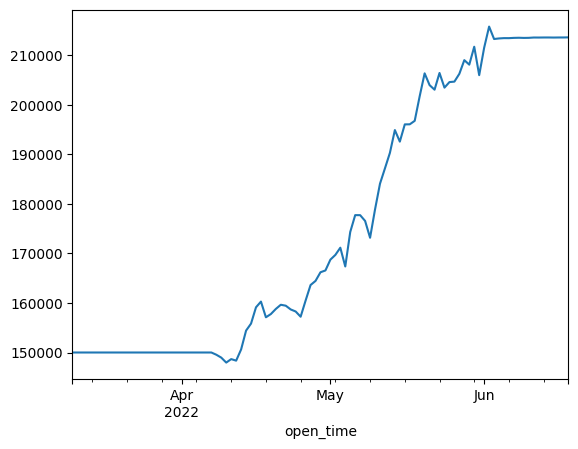

In [31]:
res.value().plot()

In [ ]:
res.print_all_trades()

In [ ]:
# DEBUG
for idx, row in spreads.iterrows():
    try:
        res = btrunner._run_single_spread(row)
    except:
        print("error: ", idx)


In [ ]:
# Run all
results = btrunner.run(spreads).to_frame("result")

In [220]:
results["total_return"] = results.result.apply(lambda e: e.portfolio.total_return())
results["total_profit"] = results.result.apply(lambda e: e.portfolio.total_profit())
results = results.join(results.result.apply(lambda e: e.aggregate_stats()))

by total_return


result  \
exchange_a exchange_b inst_type_a inst_type_b symbol                                                      
bitmex     kucoin     perpetual   perpetual   LTC     <__main__.BacktestResult object at 0x7fbd9b456...   
           ftx        perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbdae48d...   
           kucoin     perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbdad53a...   
           gateio     perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbd9b5ba...   
           bybit      perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbd9b5d9...   
           okex       perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbdb0ddf...   
binance    bitmex     perpetual   perpetual   BTC     <__main__.BacktestResult object at 0x7fbd9b1bd...   

                                                      total_return  \
exchange_a exchange_b inst_type_a inst_type_b symbol                 
bitmex     kucoin     perpetual   perpetual   LTC         0.403926   
           ftx        perpetual   perpetual   BTC         0.408515   
           kucoin     perpetual   perpetual   BTC         0.411805   
           gateio     perpetual   perpetual   BTC         0.414021   
           bybit      perpetual   perpetual   BTC         0.414436   
           okex       perpetual   perpetual   BTC         0.416707   
binance    bitmex     perpetual   perpetual   BTC         0.418150   

                                                      total_profit  \
exchange_a exchange_b inst_type_a inst_type_b symbol                 
bitmex     kucoin     perpetual   perpetual   LTC     60588.852531   
           ftx        perpetual   perpetual   BTC     61277.294003   
           kucoin     perpetual   perpetual   BTC     61770.676952   
           gateio     perpetual   perpetual   BTC     62103.114380   
           bybit      perpetual   perpetual   BTC     62165.421253   
           okex       perpetual   perpetual   BTC     62505.975512   
binance    bitmex     perpetual   perpetual   BTC     62722.516377   

                                                        avg_fees  \
exchange_a exchange_b inst_type_a inst_type_b symbol               
bitmex     kucoin     perpetual   perpetual   LTC      89.102859   
           ftx        perpetual   perpetual   BTC     139.444508   
           kucoin     perpetual   perpetual   BTC     131.278784   
           gateio     perpetual   perpetual   BTC     145.447376   
           bybit      perpetual   perpetual   BTC     131.497833   
           okex       perpetual   perpetual   BTC     122.192601   
binance    bitmex     perpetual   perpetual   BTC     109.669931   

                                                      avg_slippage  \
exchange_a exchange_b inst_type_a inst_type_b symbol                 
bitmex     kucoin     perpetual   perpetual   LTC      1096.982585   
           ftx        perpetual   perpetual   BTC       288.509676   
           kucoin     perpetual   perpetual   BTC       259.214200   
           gateio     perpetual   perpetual   BTC       233.162982   
           bybit      perpetual   perpetual   BTC       243.734917   
           okex       perpetual   perpetual   BTC       235.831498   
binance    bitmex     perpetual   perpetual   BTC       228.876669   

                                                          avg_pnl  \
exchange_a exchange_b inst_type_a inst_type_b symbol                
bitmex     kucoin     perpetual   perpetual   LTC     2375.619949   
           ftx        perpetual   perpetual   BTC     3115.784436   
           kucoin     perpetual   perpetual   BTC     3172.490075   
           gateio     perpetual   perpetual   BTC     3217.010039   
           bybit      perpetual   perpetual   BTC     3209.899597   
           okex       perpetual   perpetual   BTC     3236.722697   
binance    bitmex     perpetual   perpetual   BTC     3255.707574   

     

99th percentile: 


total_return             0.370096
total_profit         55514.349370
avg_fees               140.765139
avg_slippage          5538.623328
avg_pnl               3613.094726
profitable_trades       16.000000
losing_trades            3.060000
total_trades            16.060000
Name: 0.99, dtype: float64

<AxesSubplot:ylabel='Density'>

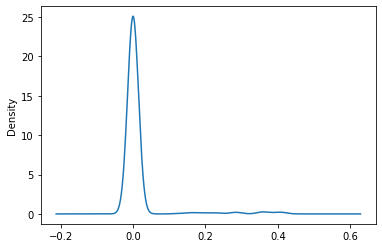

In [221]:
print("by total_return")
display(results.sort_values("total_return").tail(7))
print("99th percentile: ")
display(results.sort_values("total_return").quantile(0.99))
display(results.total_return.plot.kde())

<AxesSubplot:ylabel='Density'>

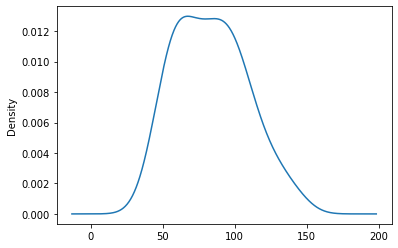

In [222]:
display(results.avg_fees.plot.kde())

<AxesSubplot:ylabel='Density'>

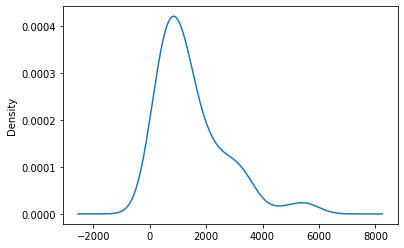

In [223]:
display(results.avg_slippage.plot.kde())

<AxesSubplot:ylabel='Density'>

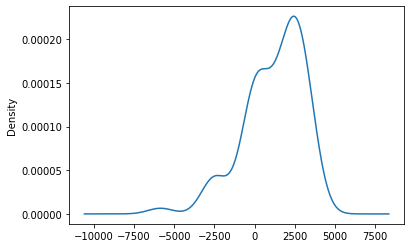

In [224]:
display(results.avg_pnl.plot.kde())